import library

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
import tensorflow_datasets as tfds

TensorFlow 2.x selected.


load the online data into the tf.data.Datasets

In [2]:
dataset, info = tfds.load('oxford_iiit_pet:3.0.0', with_info=True)

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.0.0.incompleteB028AZ/oxford_iiit_pet-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.0.0.incompleteB028AZ/oxford_iiit_pet-test.tfrecord



Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.0.0. Subsequent calls will reuse this data.


split the data

In [0]:
train_dataset = dataset['train']
test_dataset = dataset['test']


In [4]:
train_dataset

<_OptionsDataset shapes: {file_name: (), image: (None, None, 3), label: (), segmentation_mask: (None, None, 1)}, types: {file_name: tf.string, image: tf.uint8, label: tf.int64, segmentation_mask: tf.uint8}>

In [11]:
# n = 0 
# for i in train_dataset:
#   n += 1
# print(n)
it = iter(train_dataset)
a = next(it)
a['image'].shape

TensorShape([333, 500, 3])

In [16]:
a = next(it)
a['image'].shape

TensorShape([375, 500, 3])

In [12]:
info.splits['train']

<tfds.core.SplitInfo num_examples=3680>

In [8]:
info.splits['train'].num_examples

3680

define the mapping function for iterable Datesets(without data augmentation: flipping in horizontal axis)

In [0]:
def normalize(image, mask):
  image = tf.cast(image, tf.float32)/255.0
  mask -= 1
  return image, mask
  
def load_data(datapoint):
  image = tf.image.resize(datapoint['image'], size=(128, 128))
  mask = tf.image.resize(datapoint['segmentation_mask'], size=(128, 128))
  image, mask = normalize(image, mask)
  
  return image, mask

In [153]:
import time
start = time.time()
train_input = train_dataset.map(load_train_data, num_parallel_calls=tf.data.experimental.AUTOTUNE)
end = time.time()
print('used {} time'.format(end-start))

used 0.2036755084991455 time


mapping the data

In [0]:
train_input = train_dataset.map(load_data, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_input = test_dataset.map(load_data, num_parallel_calls=tf.data.experimental.AUTOTUNE)
# train_input

In [0]:
a = [1, 2, 3, 4, 5, 6]
a_t = tf.data.Dataset.from_tensor_slices(a)
# for i in a_t:
#   print(i)
a_s = a_t.cache().shuffle(buffer_size=6).batch(3).repeat(2)
a_s = a_s.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [0]:
a = [1, 2, 3, 4, 5, 6]
a_t = tf.data.Dataset.from_tensor_slices(a)
# for i in a_t:
#   print(i)
a_s = a_t.shuffle(buffer_size=6).batch(3).repeat(2)

In [0]:
a_s = a_t.shuffle(buffer_size=6, reshuffle_each_iteration=True).repeat(3)

In [74]:
for i in a_s.take(1):
  print(i)

tf.Tensor([3 2 1], shape=(3,), dtype=int32)


create the input pipeline

In [0]:
BUFFER_SIZE = 1000
BATCH_SIZE = 32
train = train_input.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
# train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test = test_input.batch(BATCH_SIZE)

In [0]:
BUFFER_SIZE = 1000
BATCH_SIZE = 32
train = train_input.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train = train.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test = test_input.batch(BATCH_SIZE)

In [0]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

In [89]:
base_model.get_layer('block_1_expand').output.shape

TensorShape([None, 64, 64, 96])

download the pretrained model to be a part of the U-Net

In [7]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)
down_stack.trainable = False

9412608/9406464 [==============================] - 0s 0us/step


finish the part of the whole model including the upsampling part 

In [8]:
!pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-iio71hw3
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-iio71hw3
  Created wheel for tensorflow-examples: filename=tensorflow_examples-20e6c703b6875b179386a4a5f81f0a7fe0b51c57_-cp36-none-any.whl size=45164 sha256=7a5a30dd3e17c868da70c0f63700d0a9655568b5058147634ab5a1ee5b5b0d5f
  Stored in directory: /tmp/pip-ephem-wheel-cache-onv7kgir/wheels/83/64/b3/4cfa02dc6f9d16bf7257892c6a7ec602cd7e0ff6ec4d7d714d
Successfully built tensorflow-examples


In [0]:
from tensorflow_examples.models.pix2pix import pix2pix

OUTPUT_CHANNELS = 3

up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

def unet_model(output_channels):

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same', activation='softmax')  #64x64 -> 128x128

  inputs = tf.keras.layers.Input(shape=[128, 128, 3])
  x = inputs

  # Downsampling through the model
  skips = down_stack(x)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

create the model 

In [0]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

define a function to display the image and ground truth and the prediction mask 

In [0]:
import matplotlib.pyplot as plt
def display(displaylist):
  title = ['image', 'true mask', 'predict mask']
  plt.figure(figsize=(1*15, len(displaylist)*15))
  for i in range(len(displaylist)):
    plt.subplot(1, len(displaylist), i+1)
    plt.axis('off')
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(displaylist[i]))
  plt.show()

In [34]:
train

<PrefetchDataset shapes: ((None, 128, 128, 3), (None, 128, 128, 1)), types: (tf.float32, tf.float32)>

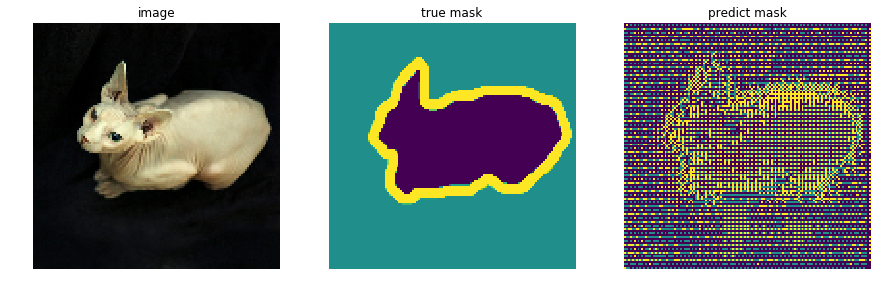

In [36]:
def create_mask(pred):
  pred = tf.argmax(pred, axis=-1)
  pred = pred[..., tf.newaxis]
  return pred[0]

for image, mask in train_input.take(1):
  predict = model.predict(image[tf.newaxis, ...])
  display([image, mask, create_mask(predict)])

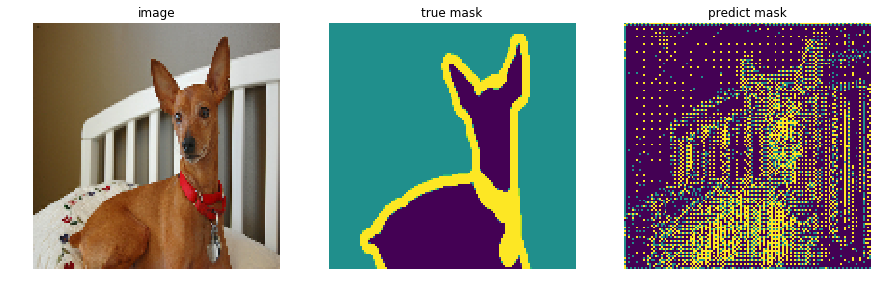

In [27]:
display([image, mask, create_mask(predict)])

In [0]:
from IPython.display import clear_output

class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    display([image, mask,
             create_mask(model.predict(image[tf.newaxis, ...]))])
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

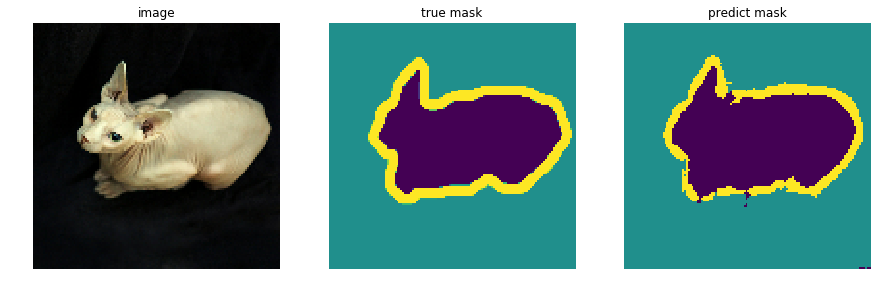


Sample Prediction after epoch 10

115/115 [==============================] - 19s 169ms/step - loss: 0.0905 - accuracy: 0.9564 - val_loss: 0.4300 - val_accuracy: 0.8747


In [37]:
EPOCHS = 10
STEPS_PER_EPOCH = info.splits['train'].num_examples//BATCH_SIZE
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test,
                          callbacks=[DisplayCallback()])

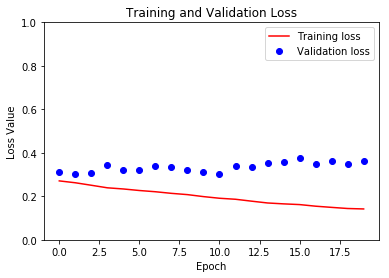

In [16]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

test 

In [0]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([image, mask,
             create_mask(model.predict(image[tf.newaxis, ...]))])

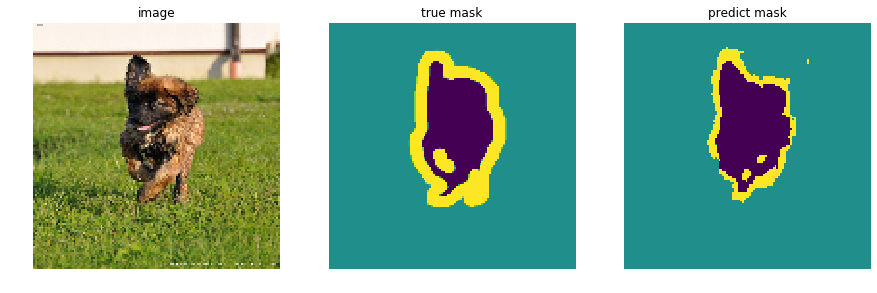

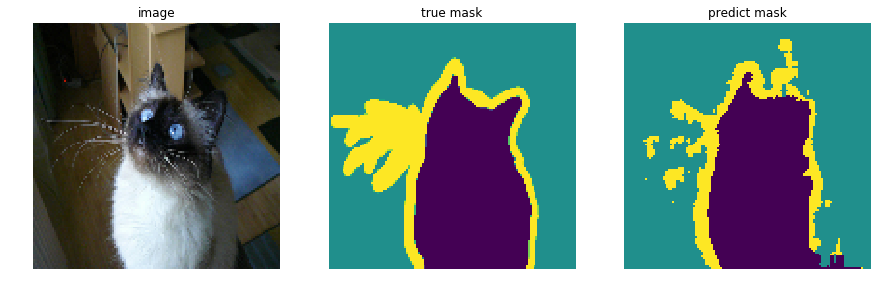

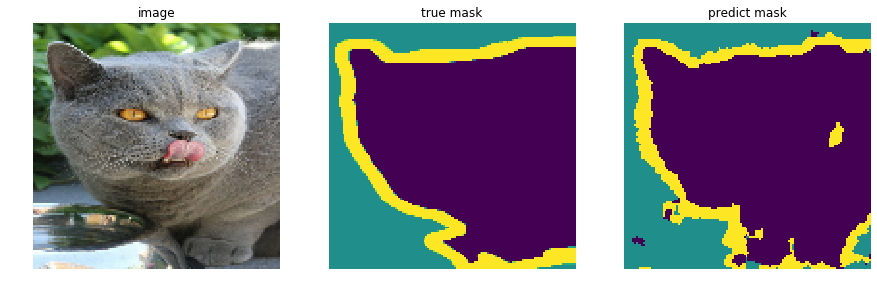

In [18]:
show_predictions(test, 3)